In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install opencv-python-headless

In [3]:
import os
import cv2
import numpy as np

def extract_frames(video_path, frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // frame_count

    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (64, 64))
            frames.append(frame)
        else:
            break
    cap.release()
    return np.array(frames)

def load_data(data_dir):
    X = []
    y = []
    labels = {'Defensive': 0, 'Pull': 1, 'Drive': 2, 'Flick': 3}

    for label in labels:
        videos_dir = os.path.join(data_dir, label)
        videos = os.listdir(videos_dir)
        print(videos_dir)
        for video in videos:
            video_path = os.path.join(videos_dir, video)
            frames = extract_frames(video_path)
            if len(frames) == 10:
                X.append(frames)
                y.append(labels[label])

    X = np.array(X)
    y = np.array(y)
    return X, y

data_dir = '/content/drive/My Drive/CroppedDetection'
X, y = load_data(data_dir)

/content/drive/My Drive/CroppedDetection/Defensive
/content/drive/My Drive/CroppedDetection/Pull
/content/drive/My Drive/CroppedDetection/Drive
/content/drive/My Drive/CroppedDetection/Flick


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0

# (batch_size, time_steps, height, width, channels)
X_train = np.reshape(X_train, (X_train.shape[0], 10, 64, 64, 3))
X_val = np.reshape(X_val, (X_val.shape[0], 10, 64, 64, 3))

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout

def create_LRCN_model(input_shape):
    model = Sequential()

    # Layer 1
    model.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3, 3), activation='tanh', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))

    # Layer 2
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='tanh', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.2)))

    # Layer 3
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='tanh', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten the output
    model.add(TimeDistributed(Flatten()))

    # Dense Layer
   # model.add(TimeDistributed(Dense(64, activation='relu')))

    # LSTM Layer
    model.add(LSTM(32))

    # Output Layer
    model.add(Dense(4, activation='softmax'))  # Assuming 4 classes for the output

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [6]:
input_shape = X_train.shape[1:]
print(input_shape)
model = create_LRCN_model(input_shape)

#model_path = '/content/drive/My Drive/ShotDetection/LRCN_model.h5'

# Load the model
#model = tf.keras.models.load_model(model_path)


model.summary()

(10, 64, 64, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/30
65/65 [==============================] - 39s 481ms/step - loss: 1.3858 - accuracy: 0.2738 - val_loss: 1.3756 - val_accuracy: 0.4070
Epoch 2/30
65/65 [==============================] - 25s 383ms/step - loss: 1.3477 - accuracy: 0.3670 - val_loss: 1.3116 - val_accuracy: 0.3333
Epoch 3/30
65/65 [==============================] - 25s 380ms/step - loss: 1.1302 - accuracy: 0.5282 - val_loss: 0.8683 - val_accuracy: 0.7054
Epoch 4/30
65/65 [==============================] - 24s 369ms/step - loss: 0.5829 - accuracy: 0.8184 - val_loss: 0.4596 - val_accuracy: 0.8527
Epoch 5/30
65/65 [==============================] - 25s 391ms/step - loss: 0.3941 - accuracy: 0.8825 - val_loss: 0.3365 - val_accuracy: 0.8798
Epoch 6/30
65/65 [==============================] - 27s 411ms/step - loss: 0.3049 - accuracy: 0.9058 - val_loss: 0.2927 - val_accuracy: 0.8953
Epoch 7/30
65/65 [==============================] - 22s 343ms/step - loss: 0.2635 - accuracy: 0.9068 - val_loss: 0.2079 - val_accuracy: 0.9147

Epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Params: {'verbose': 1, 'epochs': 30, 'steps': 65}
Keys in history.history: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


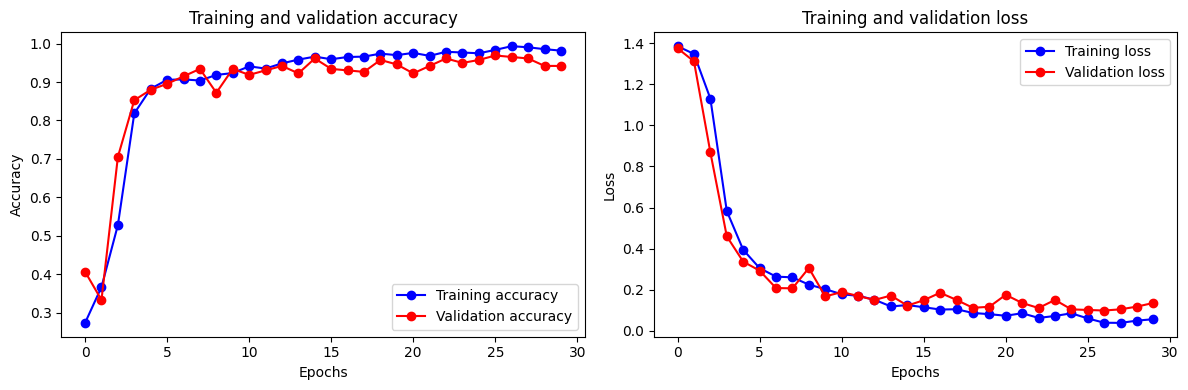

In [8]:
import matplotlib.pyplot as plt

# Extract information from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Print history details
print("Epochs:", history.epoch)
print("Params:", history.params)
print("Keys in history.history:", history.history.keys())

# Plot training vs. validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training vs. validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelBinarizer

# Make predictions
y_pred_prob = model.predict(X)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display the metrics
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Detailed classification report
print("\nClassification Report:\n", classification_report(y, y_pred))

41/41 [==============================] - 12s 278ms/step
Precision: 89.19%
Recall: 85.11%
F1 Score: 85.52%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.64      0.78       325
           1       0.96      0.91      0.94       247
           2       0.70      1.00      0.82       357
           3       0.92      0.85      0.88       359

    accuracy                           0.85      1288
   macro avg       0.89      0.85      0.86      1288
weighted avg       0.88      0.85      0.85      1288



In [12]:
model.save('/content/drive/My Drive/CroppedDetection/lrcn-tuned-model-last.keras')

In [ ]:
# model.save('/content/drive/My Drive/CroppedDetection/lrcn-tuned-model-nes-01.keras')

In [13]:
# model_path = '/content/drive/My Drive/CroppedDetection/lrcn-tuned-model.keras'

# # Load the model
# model = tf.keras.models.load_model(model_path)

In [ ]:
# from google.colab import files

# uploaded = files.upload()

# # Move the uploaded video to a specific directory
# os.makedirs('videos', exist_ok=True)
# for file_name in uploaded.keys():
#     os.rename(file_name, os.path.join('videos', file_name))

In [ ]:
# video_path = 'videos/3.mp4'
# new_frames = extract_frames(video_path)
# new_frames = np.expand_dims(new_frames, axis=0)
# new_frames = np.expand_dims(new_frames, axis=-1)

# prediction = model.predict(new_frames)
# predicted_class = np.argmax(prediction, axis=1)
# print(prediction)
# shot = {0: 'Defensive Shot', 1: 'Pull Shot', 2: 'Drive Shot', 3: 'Flick Shot'}
# print(shot[predicted_class[0]])
# # labels = {'Defensive Shot': 0,  'Pull Shot': 1, 'Drive Shot':2, 'Flick Shot':3}
# #print('Predicted class:', 'Defensive shot' if predicted_class[0] == 0 else 'Drive Shot')

1/1 [==============================] - 0s 48ms/step
[[2.8614295e-03 2.1590880e-04 9.9665856e-01 2.6406694e-04]]
Drive Shot
